In [1]:
import haiku as hk
import jax
import jax.random as jrnd
import jax.numpy as jnp

import numpy as np
import optax

In [2]:
from phasor_jax.modules import *
from phasor_jax.utils import *
from phasor_jax.training import *

In [3]:
import matplotlib.pyplot as plt

Activation fn Demo

In [4]:
angles = jnp.linspace(-1.1, 1.1, 501)

In [5]:
zvals = jnp.exp(jnp.pi * (0 + 1j) * angles)

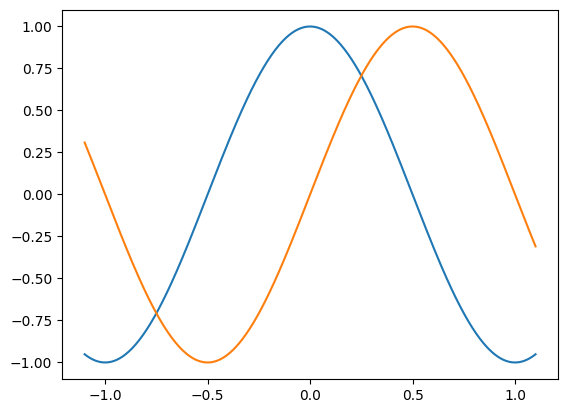

In [6]:
plt.plot(angles, jnp.real(zvals))
plt.plot(angles, jnp.imag(zvals))

In [7]:
angles2 = phasor_act(zvals)

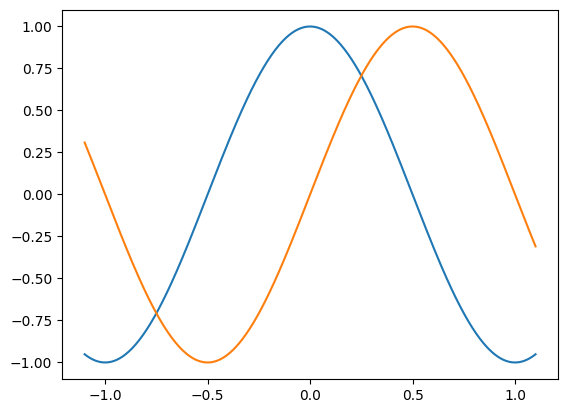

In [8]:
plt.plot(angles, jnp.real(zvals))
plt.plot(angles, jnp.imag(zvals))

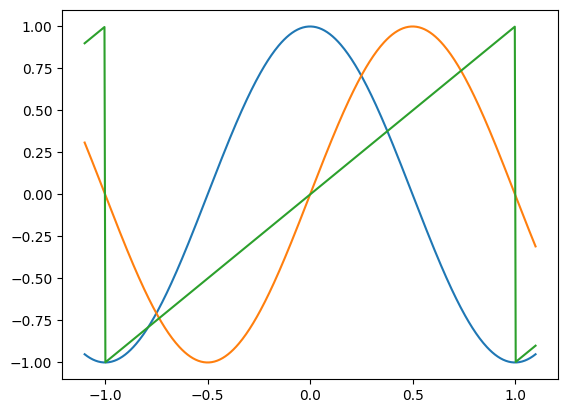

In [9]:
plt.plot(angles, jnp.real(zvals))
plt.plot(angles, jnp.imag(zvals))
plt.plot(angles, angles2)

Model

In [10]:
def chain(x, spiking: bool = False):
    if spiking:
        x = phase_to_train(x)

    x1 = conv_1d(1)(x, spiking=spiking)
    x2 = conv_1d(1)(x1, spiking=spiking)

    return (x1, x2)

In [11]:
def layer(x, spiking: bool = False, **kwargs):
    x1 = conv_1d(1)(x, spiking=spiking, **kwargs)
    return x1

In [12]:
chain_fn = hk.without_apply_rng(hk.transform(chain))

In [13]:
layer_fn = hk.without_apply_rng(hk.transform(layer))

In [14]:
in0 = jnp.zeros((1,1))

In [15]:
key = jax.random.PRNGKey(42)

In [16]:
params = chain_fn.init(key, in0)

/Users/wilkie/anaconda3/envs/jax/lib/python3.10/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [17]:
params['phasor_dense']['w'] = jnp.ones((1,1))
params['phasor_dense_1']['w'] = jnp.ones((1,1))

In [18]:
params['phasor_dense']['bz'] = jnp.zeros((1))
params['phasor_dense_1']['bz'] = jnp.zeros((1))

In [19]:
za = (1 + 0j)*jnp.exp(in0*1j*jnp.pi)

In [20]:
za

DeviceArray([[1.+0.j]], dtype=complex64)

In [21]:
phasor_act(za)

DeviceArray([[0.]], dtype=float32)

In [22]:
chain_fn.apply(params, in0)

(DeviceArray([[0.]], dtype=float32), DeviceArray([[0.]], dtype=float32))

In [23]:
spk0, spk1 = chain_fn.apply(params, in0, spiking = True)

In [24]:
spk0

SpikeTrain(indices=[array([0, 0, 0, 0, 0])], times=array([1.76, 2.76, 3.76, 4.75, 5.75]), full_shape=(1, 1))

In [33]:
train_to_phase(spk0, offset=0.25)

array([[[0.  , 0.02, 0.02, 0.02, 0.  , 0.  , 0.  ]]])

In [25]:
spk1

SpikeTrain(indices=[array([0, 0, 0, 0, 0, 0, 0])], times=array([3.02, 4.02, 5.01, 6.01, 7.01, 8.01, 9.01]), full_shape=(1, 1))

In [34]:
train_to_phase(spk1, offset=0.50)

array([[[0.  , 0.  , 0.04, 0.04, 0.02, 0.02, 0.02, 0.02, 0.02, 0.  ,
         0.  ]]])

In [27]:
spks = phase_to_train(in0, repeats = 3)

In [28]:
spks

SpikeTrain(indices=[array([0, 0, 0])], times=array([0.5, 1.5, 2.5], dtype=float32), full_shape=(1, 1))

In [29]:
soln = layer_fn.apply(params, spks, spiking = True, return_solution = True)

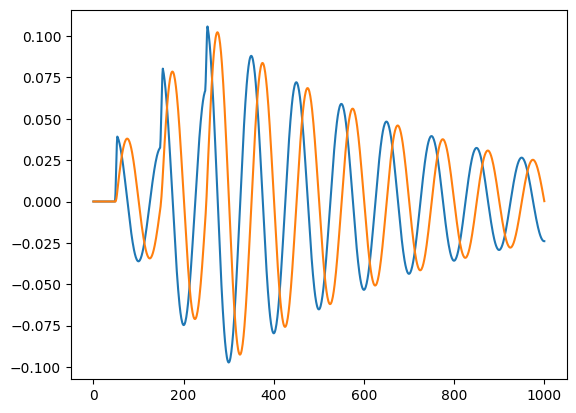

In [30]:
plt.plot(np.real(soln.y.ravel()))
plt.plot(np.imag(soln.y.ravel()))